In [20]:
"""
2026-01-07 Maria Yli-Heikkilä

Here we plot time series of Shannon index (supply diversity) that is calculated over all items of a country
after the rolling mean is applied.

All in kg.

What shall we do with the non-complete time series, e.g. post Soviet Union countries?


"""


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import faostat
import warnings
import numpy as np

myElement = 'Food supply quantity (kg/capita/yr)'

(204, 204)

In [ ]:
# Results in:
fp = '/Users/myliheik/Documents/myPython/FBSadjusted/results/interpolatedLinear/Food-supply-quantity-kg-capita-yr-2023.csv'
df = pd.read_csv(fp)

# prepare dictionaries:
myAreaDict = df.set_index('Area').to_dict()['Area Code']
myAreaDictReverse = df.set_index('Area Code').to_dict()['Area']

myItemDict = df.set_index('Item').to_dict()['Item Code']
myItemDictReverse = df.set_index('Item Code').to_dict()['Item']

myAreas = df['Area'].unique().tolist()

len(myAreas), len(myAreaDict)

In [2]:
import faostat
regions = faostat.get_par_df('FBS', 'regions')
countries = faostat.get_par_df('FBS', 'countries')

In [3]:
timeSeriesLength = 2023-1961+1
print(f'Time series lenght should be {timeSeriesLength}')

Time series lenght should be 63


In [29]:
# Applied for a country:
def rollingMeanForOneItem(df, myItemCode, timeSeriesLength):
    # Subset df:
    df2 = df[(df['Element'] == myElement) & (df['Item Code'] == myItemCode)]
    df2 = df2.assign(Time = pd.to_datetime(df2.Year, format='%Y'))
    if df2['Year'].duplicated().any():
        print('Duplicated years!')
    #if len(df2) is not timeSeriesLength:
    #    #print(f'Time series lenght is {len(df2)} and it should be {timeSeriesLength}')
    #    pass
    df3 = df2[['Time', 'NAsInterpolated']]
    df4 = df3.set_index('Time').sort_index()
    # moving average:
    df4[myItemCode] = df4['NAsInterpolated'].rolling(3).mean()
    
    return df4[myItemCode]

In [107]:
df['Unit'].value_counts()

Unit
kg/cap    1187218
Name: count, dtype: int64

In [108]:
df['Element'].value_counts()

Element
Food supply quantity (kg/capita/yr)    1187218
Name: count, dtype: int64

In [30]:
drop = ('Alcoholic Beverages', 'Beverages, Alcoholic', 'Wine', 'Beer', 'Cloves', 'Spices', 'Pepper', 
       'Spices, Other')

In [31]:
myCountryShannon = []
myCountries = []

# for each country:
for myCountry in myAreaDict.keys():
    allItems = []
    #print(myCountry)
    # subset country:
    df2 = df[(df['Area'] == myCountry)]

    # take all items:
    myItemDict = df2.set_index('Item').to_dict()['Item Code']
    # drop items that we dont need (spices, non-food, alcohol):
    newItemDict = {k: v for k, v in myItemDict.items() if k not in drop}
    
    # iterate each item:
    for myItem, myItemCode in newItemDict.items():
        #print(myItem)
        allItems.append(rollingMeanForOneItem(df2, myItemCode, timeSeriesLength))
        
    myCountrydf = pd.concat(allItems, axis = 1)
    # row sums:
    myCountrydf['AnnualTotal'] = myCountrydf.sum(axis = 1)
    # share of each item from the Annual Total:
    myCountryShares = myCountrydf.div(myCountrydf['AnnualTotal'], axis=0)    
    # each item ** itsef:
    myCountryPowers = myCountryShares.pow(myCountryShares.values)
    myCountryProduct = myCountryPowers.prod(min_count=1, axis = 1) # at least one item value per year
    Shannon = np.log(1/myCountryProduct)
    myCountryShannon.append(Shannon)
    myCountries.append(myCountry)
    

In [32]:
dfShannon = pd.concat(myCountryShannon, axis = 1)
dfShannon.columns = myCountries
dfShannon

,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,Least Developed Countries (LDCs),Least Developed Countries,Land Locked Developing Countries (LLDCs),Land Locked Developing Countries,Small Island Developing States (SIDS),Small Island Developing States,Low Income Food Deficit Countries (LIFDCs),Low Income Food Deficit Countries,Net Food Importing Developing Countries (NFIDCs),Net Food Importing Developing Countries
Time,,,,,,,,,,,,,,,,,,,,,
1961-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-01,2.275437,2.609992,2.848036,2.138960,2.496526,3.047455,NaN,3.136877,3.151010,NaN,...,NaN,2.931820,NaN,3.115011,NaN,3.309622,NaN,3.058923,NaN,3.127878
1964-01-01,2.296682,2.603369,2.838902,2.185295,2.507668,3.052805,NaN,3.138547,3.158496,NaN,...,NaN,2.940923,NaN,3.120861,NaN,3.311759,NaN,3.052047,NaN,3.135517
1965-01-01,2.320164,2.591066,2.832284,2.174148,2.563881,3.058748,NaN,3.144721,3.157097,NaN,...,NaN,2.945724,NaN,3.126531,NaN,3.309789,NaN,3.056831,NaN,3.138857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01,2.605781,2.914817,2.937760,2.827507,3.267466,3.212463,3.002113,3.319053,3.295914,2.896380,...,3.205414,NaN,3.321190,NaN,3.339392,NaN,3.286844,NaN,3.319706,NaN
2020-01-01,2.598758,2.915448,2.923728,2.772060,3.276292,3.235955,3.015746,3.317010,3.296526,2.916761,...,3.204290,NaN,3.326004,NaN,3.334691,NaN,3.296190,NaN,3.321959,NaN
2021-01-01,2.594388,2.913583,2.921514,2.761573,3.281700,3.254703,3.014552,3.315779,3.289525,2.941588,...,3.207800,NaN,3.328855,NaN,3.335722,NaN,3.304721,NaN,3.324379,NaN


In [ ]:
# pitää vielä normalisoida

In [33]:
def plotShannon(data, axes, palette, myElement):
    
        
    df5 = data.reset_index()
    
    df6 = pd.melt(df5, id_vars=['Time'], value_vars=data.columns,
   var_name = 'Area', value_name = 'Diversity in ' + myElement)
    
        
    ax = sns.lineplot(df6, y = 'Diversity in ' + myElement, x = 'Time', hue = 'Area', palette=palette, ax = axes)

    ax.tick_params(axis='x', rotation=45)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    ax.set_title(f'Diversity in {myElement}')
    ax.set_ylabel(f'Shannon index')


<function matplotlib.pyplot.show(close=None, block=None)>

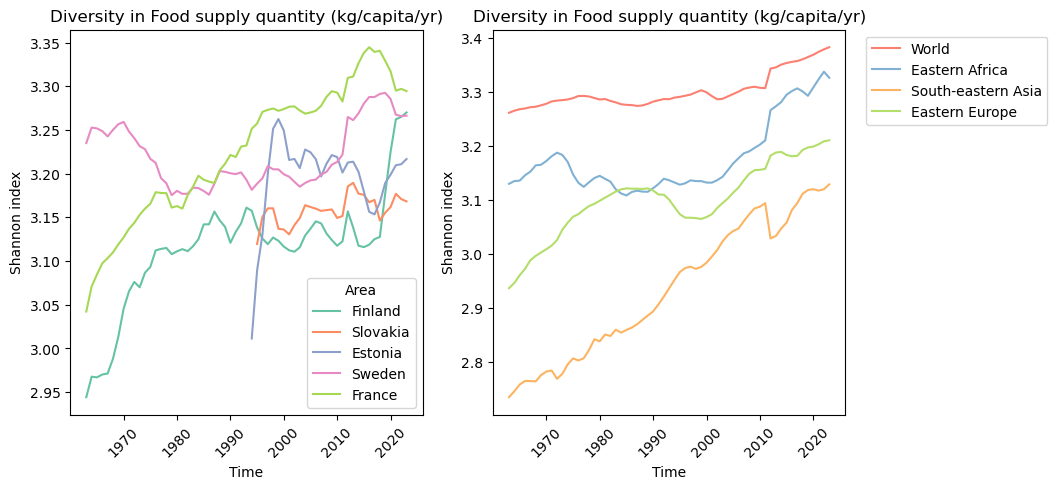

In [34]:
palette1 = sns.color_palette("Set2") 
palette11 = sns.color_palette("Set2")[1:]
palette2 = sns.color_palette("Set3")[3:] 

warnings.filterwarnings("ignore")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

myCountry = 'Finland'
myElement = 'Food supply quantity (kg/capita/yr)'


# Take regions:

regions = ['World',
'Eastern Africa',
#'Middle Africa',
#'Northern Africa',
#'Southern Africa',
#'Western Africa',
#'Northern America',
#'Central America',
#'Caribbean',
#'South America',
#'Central Asia',
#'Eastern Asia',
#'Southern Asia',
'South-eastern Asia',
#'Western Asia',
'Eastern Europe',
#'Northern Europe',
#'Southern Europe',
#'Western Europe',
#'Oceania',
#'Australia and New Zealand',
#'Melanesia',
#'Micronesia',
#'Polynesia'
          ]

countries = [
    'Finland', 'Slovakia', 'Estonia', 'Sweden', 'France'
    
]

plotShannon(dfShannon[countries], ax1, palette1, myElement)

plotShannon(dfShannon[regions], ax2, palette2, myElement)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

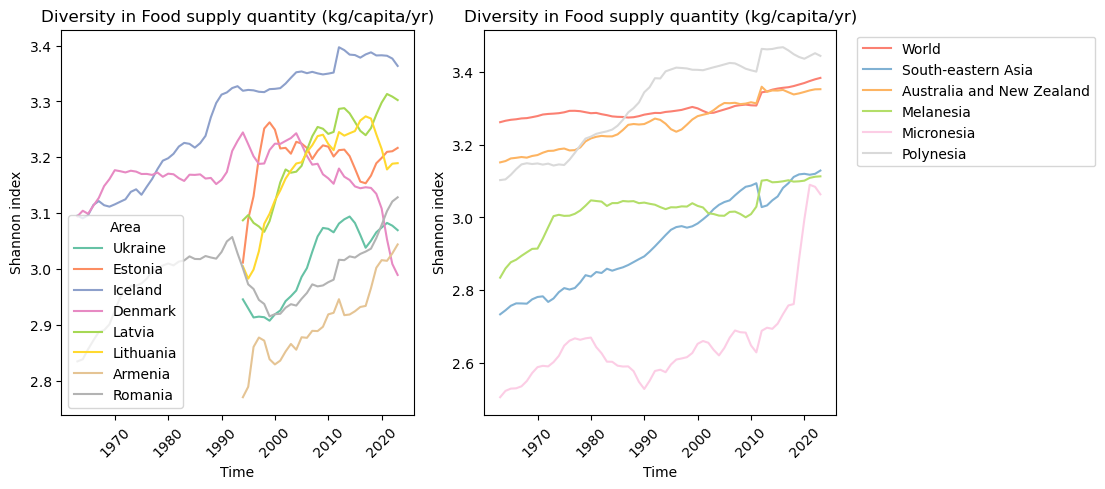

In [37]:
palette1 = sns.color_palette("Set2") 
palette11 = sns.color_palette("Set2")[1:]
palette2 = sns.color_palette("Set3")[3:] 

warnings.filterwarnings("ignore")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

myCountry = 'Finland'
myElement = 'Food supply quantity (kg/capita/yr)'


# Take regions:

regions = ['World',
#'Eastern Africa',
#'Middle Africa',
#'Northern Africa',
#'Southern Africa',
#'Western Africa',
#'Northern America',
#'Central America',
#'Caribbean',
#'South America',
#'Central Asia',
#'Eastern Asia',
#'Southern Asia',
'South-eastern Asia',
#'Western Asia',
#'Eastern Europe',
#'Northern Europe',
#'Southern Europe',
#'Western Europe',
#'Oceania',
'Australia and New Zealand',
'Melanesia',
'Micronesia',
'Polynesia'
          ]

countries = [
    'Ukraine', 'Estonia', 'Iceland', 'Denmark', 'Latvia', 'Lithuania', 'Armenia', 'Romania'
    
]

plotShannon(dfShannon[countries], ax1, palette1, myElement)

plotShannon(dfShannon[regions], ax2, palette2, myElement)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

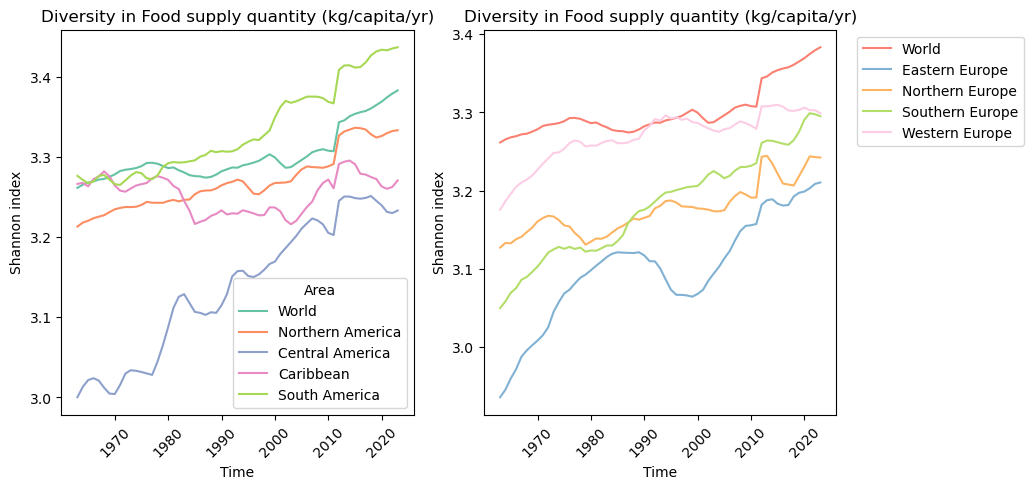

In [38]:
palette1 = sns.color_palette("Set2") 
palette11 = sns.color_palette("Set2")[1:]
palette2 = sns.color_palette("Set3")[3:] 

warnings.filterwarnings("ignore")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

myCountry = 'Finland'
myElement = 'Food supply quantity (kg/capita/yr)'


# Take regions:

regions = ['World',
#'Eastern Africa',
#'Middle Africa',
#'Northern Africa',
#'Southern Africa',
#'Western Africa',
'Northern America',
'Central America',
'Caribbean',
'South America',
#'Central Asia',
#'Eastern Asia',
#'Southern Asia',
#'South-eastern Asia',
#'Western Asia',
#'Eastern Europe',
#'Northern Europe',
#'Southern Europe',
#'Western Europe',
#'Oceania',
#'Australia and New Zealand',
#'Melanesia',
#'Micronesia',
#'Polynesia'
          ]

regions2 = ['World',
#'Eastern Africa',
#'Middle Africa',
#'Northern Africa',
#'Southern Africa',
#'Western Africa',
#'Northern America',
#'Central America',
#'Caribbean',
#'South America',
#'Central Asia',
#'Eastern Asia',
#'Southern Asia',
#'South-eastern Asia',
#'Western Asia',
'Eastern Europe',
'Northern Europe',
'Southern Europe',
'Western Europe',
#'Oceania',
#'Australia and New Zealand',
#'Melanesia',
#'Micronesia',
#'Polynesia'
          ]

countries = [
    'Ukraine', 'Estonia', 'Iceland', 'Denmark', 'Latvia', 'Lithuania', 'Armenia', 'Romania'
    
]

plotShannon(dfShannon[regions], ax1, palette1, myElement)

plotShannon(dfShannon[regions2], ax2, palette2, myElement)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

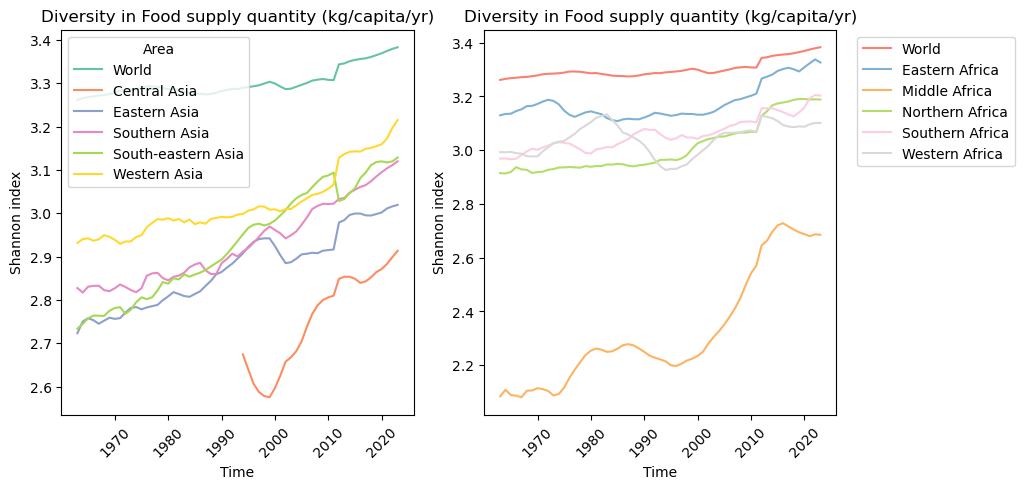

In [40]:
palette1 = sns.color_palette("Set2") 
palette11 = sns.color_palette("Set2")[1:]
palette2 = sns.color_palette("Set3")[3:] 

warnings.filterwarnings("ignore")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

myCountry = 'Finland'
myElement = 'Food supply quantity (kg/capita/yr)'


# Take regions:

regions = ['World',
#'Eastern Africa',
#'Middle Africa',
#'Northern Africa',
#'Southern Africa',
#'Western Africa',
#'Northern America',
#'Central America',
#'Caribbean',
#'South America',
'Central Asia',
'Eastern Asia',
'Southern Asia',
'South-eastern Asia',
'Western Asia',
#'Eastern Europe',
#'Northern Europe',
#'Southern Europe',
#'Western Europe',
#'Oceania',
#'Australia and New Zealand',
#'Melanesia',
#'Micronesia',
#'Polynesia'
          ]

regions2 = ['World',
'Eastern Africa',
'Middle Africa',
'Northern Africa',
'Southern Africa',
'Western Africa',
#'Northern America',
#'Central America',
#'Caribbean',
#'South America',
#'Central Asia',
#'Eastern Asia',
#'Southern Asia',
#'South-eastern Asia',
#'Western Asia',
#'Eastern Europe',
#'Northern Europe',
#'Southern Europe',
#'Western Europe',
#'Oceania',
#'Australia and New Zealand',
#'Melanesia',
#'Micronesia',
#'Polynesia'
          ]

countries = [
    'Ukraine', 'Estonia', 'Iceland', 'Denmark', 'Latvia', 'Lithuania', 'Armenia', 'Romania'
    
]

plotShannon(dfShannon[regions], ax1, palette1, myElement)

plotShannon(dfShannon[regions2], ax2, palette2, myElement)
plt.show

## let's analyse how the functions works

In [21]:
myCountryShannon = []
myCountries = []
myShannon = []
myPowers = []
myProducts = []
myShares = []

# for each country:
for myCountry in ['Finland', 'Ukraine']:
    allItems = []
    #print(myCountry)
    # subset country:
    df2 = df[(df['Area'] == myCountry)]

    # take all items:
    myItemDict = df2.set_index('Item').to_dict()['Item Code']
    # drop items that we dont need (spices, non-food, alcohol):
    newItemDict = {k: v for k, v in myItemDict.items() if k not in drop}

    # iterate each item:
    for myItem, myItemCode in newItemDict.items():
        #print(myItem)
        allItems.append(rollingMeanForOneItem(df2, myItemCode, timeSeriesLength))

    myCountrydf = pd.concat(allItems, axis = 1)
    # row sums:
    myCountrydf['AnnualTotal'] = myCountrydf.sum(axis = 1)
    
    # share of each item from the Annual Total:
    myCountryShares = myCountrydf.div(myCountrydf['AnnualTotal'], axis=0)   
    myShares.append(myCountryShares)
    
    # each item ** itsef:
    myCountryPowers = myCountryShares.pow(myCountryShares.values)
    myPowers.append(myCountryPowers)
    
    myCountryProduct = myCountryPowers.prod(min_count=1, axis = 1) # at least one item value per year
    myProducts.append(myCountryProduct)
    
    Shannon = np.log(1/myCountryProduct)
    myShannon.append(Shannon)
    
    myCountryShannon.append(Shannon)
    myCountries.append(myCountry)


In [28]:
dfShannon = pd.concat(myCountryShannon, axis = 1)
dfShannon.columns = myCountries

dfmyShares = pd.concat(myShares, axis = 1)
#dfmyShares.columns = myCountries

dfmyPowers = pd.concat(myPowers, axis = 1)
#dfmyPowers.columns = myCountries


dfmyProducts = pd.concat(myProducts, axis = 1)
dfmyProducts.columns = myCountries

In [23]:
myCountries

['Finland', 'Ukraine']

In [27]:
dfmyShares

,2905.0,2511.0,2513.0,2515.0,2516.0,2520.0,2520.0,2907.0,2531.0,2533.0,...,2807.0,2518.0,2532.0,2535.0,2546.0,2552.0,2557.0,2570.0,2616.0,AnnualTotal
Time,,,,,,,,,,,,,,,,,,,,,
1961-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-01,0.113526,0.073605,0.006621,0.023750,0.005023,0.000146,0.000146,0.088794,0.088776,0.000031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-01-01,0.108752,0.070709,0.005912,0.022336,0.004768,0.000257,0.000257,0.089372,0.089354,0.000031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-01-01,0.105901,0.069043,0.005826,0.021125,0.004573,0.000353,0.000353,0.090656,0.090638,0.000031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01,0.082300,0.054292,0.003843,0.015729,0.002050,0.000711,0.000711,0.040323,0.040064,0.000255,...,0.002509,0.000297,0.0,NaN,NaN,0.000626,NaN,NaN,NaN,1.0
2020-01-01,0.084957,0.054594,0.007427,0.014328,0.001653,0.000774,0.000774,0.041121,0.040851,0.000268,...,0.002714,0.000108,0.0,NaN,NaN,0.000488,NaN,NaN,NaN,1.0
2021-01-01,0.088452,0.055374,0.011560,0.013023,0.001020,0.000703,0.000703,0.041828,0.041562,0.000266,...,0.002577,0.000014,0.0,0.0,0.000741,0.000325,0.000027,0.0,0.0,1.0
